# Ensable model

In [1]:
from typing import Tuple

import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

## Prepare dataset directory

In [2]:
from pathlib import Path

DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

## Prepare & Visualise dataset

In [3]:
train_data = MNIST(root=DATA_DIR, train=True, download=True, transform=ToTensor())
test_data = MNIST(root=DATA_DIR, train=False, download=True, transform=ToTensor())

# take only small subset of training data to speed up the process
from torch.utils.data import Subset

TRAIN_SIZE = 5_000
train_data = Subset(train_data, range(TRAIN_SIZE))

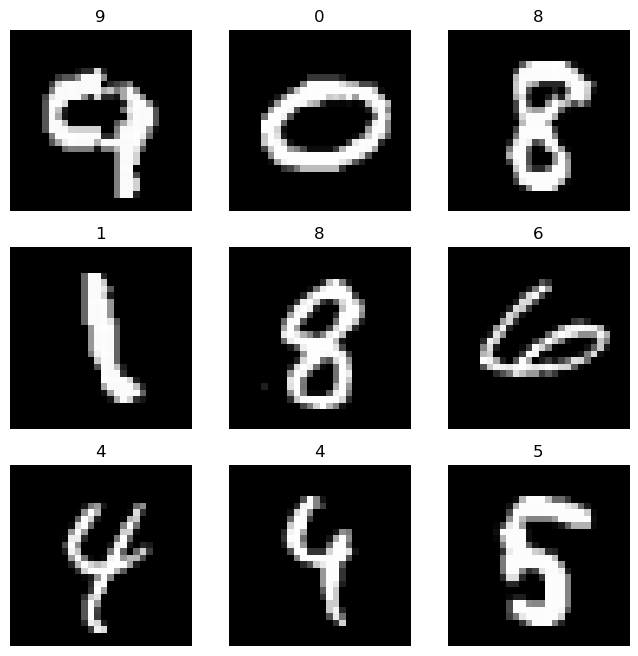

In [4]:
figure = plt.figure(figsize=(8, 8))

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), "gray")

plt.show()

# Prepare DataLoader

In [5]:
batch_size = 64

from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

Features batch shape: torch.Size([64, 1, 28, 28])
Labeels batch shape: torch.Size([64])


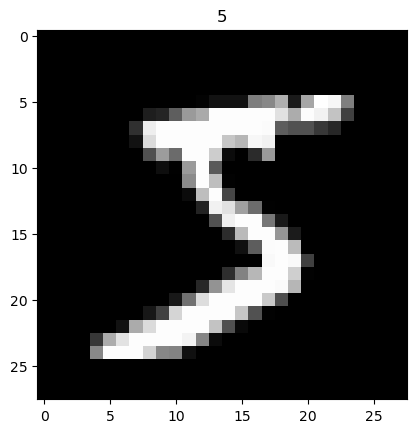

In [6]:
# DataLoader usage example
train_features, train_labels = next(iter(train_loader))
print(f"Features batch shape: {train_features.size()}")
print(f"Labeels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].item()
plt.imshow(img, "gray")
plt.title(label)
plt.show()

## Create device-agnostic code

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Create model

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        return self.linear_relu_stack(x)

# Optimizing the model parameters

In [9]:
MODELS_NUM = 10
learning_rate = 6e-3
epochs = 10

In [10]:
loss_fn = nn.MSELoss()
models = [NeuralNetwork().to(device) for _ in range(MODELS_NUM)]
optimizers = [torch.optim.SGD(model.parameters(), lr=learning_rate) for model in
              models]

In [11]:
import torch.nn.functional as F
from typing import Tuple


def train(data_loader: DataLoader, model: nn.Module, optimizer: torch.optim.Optimizer, loss_fn: nn.Module, *,
          save_preds: bool = False) -> Tuple[float, torch.Tensor]:
    """
    Train the model for one epoch
    :return: average loss, model predictions
    """
    dataset_size = len(data_loader.dataset)
    model.train()
    total_loss = 0
    batches_preds = []

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y = F.one_hot(y, num_classes=10).float()

        # Compute prediction error
        pred = model(X)
        if save_preds:
            batches_preds.append(pred)
        loss = loss_fn(pred, y)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 35 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"\tloss: {loss:>7f}  [{current:>5d}/{dataset_size:>5d}]")
    
    print(f"\tAvg loss: {total_loss / len(data_loader)}")
    model_preds = torch.cat(batches_preds) if save_preds else None
    return total_loss / len(data_loader), model_preds

In [12]:
def test(data_loader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> Tuple[float, float]:
    """
    Evaluate the model's performance on the test dataset 
    :return: average loss, accuracy
    """
    dataset_size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y = F.one_hot(y, num_classes=10).float()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= dataset_size
        print(f"\tTest Error: \n\tAccuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100 * correct

## Train models

In [13]:
train_losses = [list() for _ in range(MODELS_NUM)]
test_losses = [list() for _ in range(MODELS_NUM)]
test_accuracies = [list() for _ in range(MODELS_NUM)]

In [14]:
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    for i, (model, optimizer) in enumerate(zip(models, optimizers)):
        print(f"\tModel #{i + 1}")
        train_loss, _ = train(train_loader, model, optimizer, loss_fn)
        test_loss, test_accuracy = test(test_loader, model, loss_fn)

        # Save metrics
        train_losses[i].append(train_loss)
        test_losses[i].append(test_loss)
        test_accuracies[i].append(test_accuracy)
print("Done!")

Epoch 1
-------------------------------
	Model #1
	loss: 0.098538  [   64/ 5000]
	loss: 0.096124  [ 2304/ 5000]
	loss: 0.093927  [ 4544/ 5000]
	Avg loss: 0.09672579188135606
	Test Error: 
	Accuracy: 13.6%, Avg loss: 0.094284 

	Model #2
	loss: 0.100966  [   64/ 5000]
	loss: 0.096228  [ 2304/ 5000]
	loss: 0.094566  [ 4544/ 5000]
	Avg loss: 0.09738383498750156
	Test Error: 
	Accuracy: 13.6%, Avg loss: 0.094469 

	Model #3
	loss: 0.101789  [   64/ 5000]
	loss: 0.098069  [ 2304/ 5000]
	loss: 0.093480  [ 4544/ 5000]
	Avg loss: 0.09802884089795849
	Test Error: 
	Accuracy: 13.6%, Avg loss: 0.095069 

	Model #4
	loss: 0.101940  [   64/ 5000]
	loss: 0.097598  [ 2304/ 5000]
	loss: 0.095828  [ 4544/ 5000]
	Avg loss: 0.09788152933875217
	Test Error: 
	Accuracy: 12.2%, Avg loss: 0.095059 

	Model #5
	loss: 0.101193  [   64/ 5000]
	loss: 0.097641  [ 2304/ 5000]
	loss: 0.096149  [ 4544/ 5000]
	Avg loss: 0.0984364192508444
	Test Error: 
	Accuracy: 10.9%, Avg loss: 0.095604 

	Model #6
	loss: 0.100241 

## Print loss for each model

In [15]:
def plot_models_metrics(models_train_loss, models_test_loss, models_test_accuracy, *, ensamble_last=False):
    def plot_metric(metric, title, ylabel):
        metric_array = torch.tensor(metric)

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)

        for i, model_metric in enumerate(metric):
            if ensamble_last and i == len(models_train_loss) - 1:
                plt.plot(model_metric, label=f"Ensamble", color='red', marker="o", linestyle="--", linewidth=1.4)
                continue
            plt.plot(model_metric, label=f"Model {i}", marker="o", alpha=.8)

        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.xticks(list(range(len(metric_array[0]))))
        plt.legend()

        plt.show()

    plot_metric(models_train_loss, "Train Loss", "Loss")
    plot_metric(models_test_loss, "Test Loss", "Loss")
    plot_metric(models_test_accuracy, "Test Accuracy", "Accuracy")

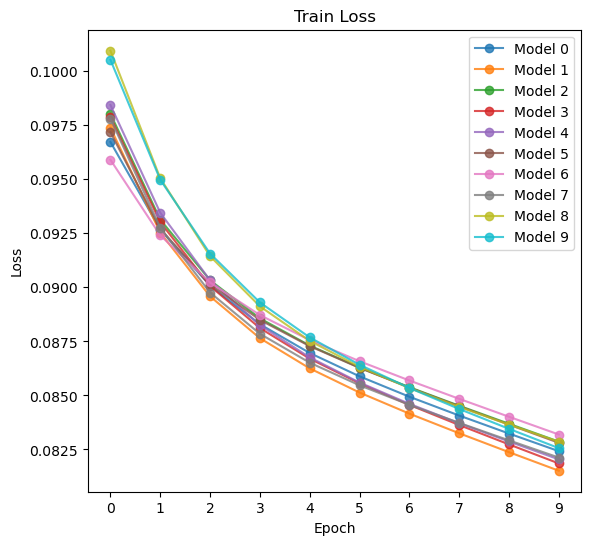

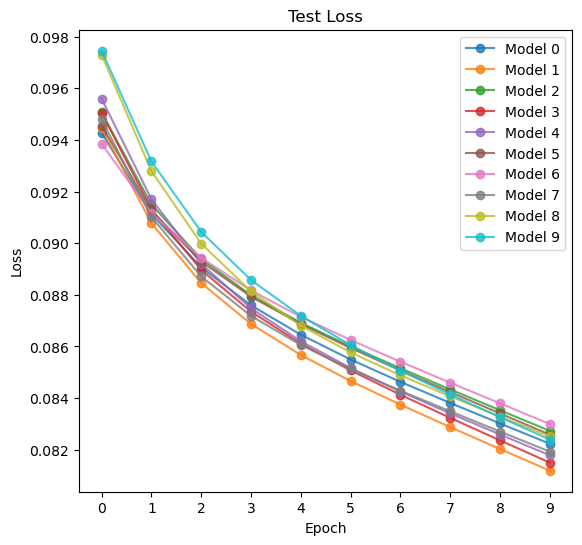

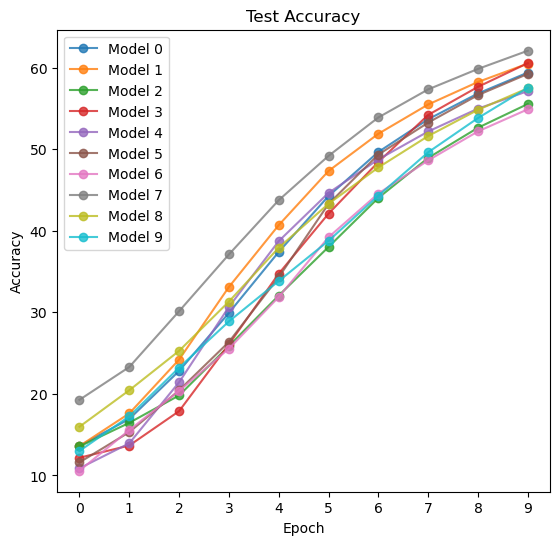

In [16]:
plot_models_metrics(train_losses, test_losses, test_accuracies)

## Now let's focus on training models including EnsambleModel

In [17]:
from typing import List

class EnsambleModel(nn.Module):
    def __init__(self, model_list):
        super().__init__()
        self.model_list = model_list

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        outputs = [model(x) for model in self.model_list]
        return torch.stack(outputs, dim=2).mean(dim=2)

    @staticmethod
    def calculate_loss(models_preds: List[torch.Tensor], target: torch.Tensor, loss_fn: nn.Module) -> float:
        ensamble_pred = torch.stack(models_preds, dim=2).mean(dim=2)
        return loss_fn(ensamble_pred, target).item()

In [18]:
models = [NeuralNetwork().to(device) for _ in range(MODELS_NUM)]
ensamble_model = EnsambleModel(models)
optimizers = [torch.optim.SGD(model.parameters(), lr=learning_rate) for model in models]

In [19]:
train_losses = [list() for _ in range(MODELS_NUM + 1)]
test_losses = [list() for _ in range(MODELS_NUM + 1)]
test_accuracies = [list() for _ in range(MODELS_NUM + 1)]

In [20]:
all_labels = torch.cat([y.to(device) for _, y in train_loader])
all_labels = F.one_hot(all_labels, num_classes=10).float()

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    models_preds = [None for _ in range(MODELS_NUM)]
    for i, (model, optimizer) in enumerate(zip(models, optimizers)):
        print(f"\tModel #{i + 1}")
        train_loss, model_preds = train(train_loader, model, optimizer, loss_fn, save_preds=True)
        test_loss, test_acc = test(test_loader, model, loss_fn)
        models_preds[i] = model_preds
        # Save metrics
        train_losses[i].append(train_loss)
        test_losses[i].append(test_loss)
        test_accuracies[i].append(test_acc)
        
    # Ensemble
    print(f"\tModel #EnsambleModel")
    train_loss = EnsambleModel.calculate_loss(models_preds, all_labels, loss_fn)
    print(f"\tTrain Loss: {train_loss:>8f}")
    test_loss, test_acc = test(test_loader, ensamble_model, loss_fn)
    train_losses[-1].append(train_loss)
    test_losses[-1].append(test_loss)
    test_accuracies[-1].append(test_acc)
print("Done!")

Epoch 1
-------------------------------
	Model #1
	loss: 0.100428  [   64/ 5000]
	loss: 0.096384  [ 2304/ 5000]
	loss: 0.094287  [ 4544/ 5000]
	Avg loss: 0.09663167567569998
	Test Error: 
	Accuracy: 14.6%, Avg loss: 0.094184 

	Model #2
	loss: 0.107518  [   64/ 5000]
	loss: 0.102737  [ 2304/ 5000]
	loss: 0.100051  [ 4544/ 5000]
	Avg loss: 0.10188979315984098
	Test Error: 
	Accuracy: 13.4%, Avg loss: 0.097972 

	Model #3
	loss: 0.099538  [   64/ 5000]
	loss: 0.095349  [ 2304/ 5000]
	loss: 0.094804  [ 4544/ 5000]
	Avg loss: 0.09633248582293716
	Test Error: 
	Accuracy: 11.7%, Avg loss: 0.093828 

	Model #4
	loss: 0.102891  [   64/ 5000]
	loss: 0.099657  [ 2304/ 5000]
	loss: 0.096263  [ 4544/ 5000]
	Avg loss: 0.09956986315642731
	Test Error: 
	Accuracy: 10.7%, Avg loss: 0.096463 

	Model #5
	loss: 0.102398  [   64/ 5000]
	loss: 0.100066  [ 2304/ 5000]
	loss: 0.096148  [ 4544/ 5000]
	Avg loss: 0.09827248318285882
	Test Error: 
	Accuracy: 18.4%, Avg loss: 0.095227 

	Model #6
	loss: 0.106659

## Visualize EnsambleModel learning process

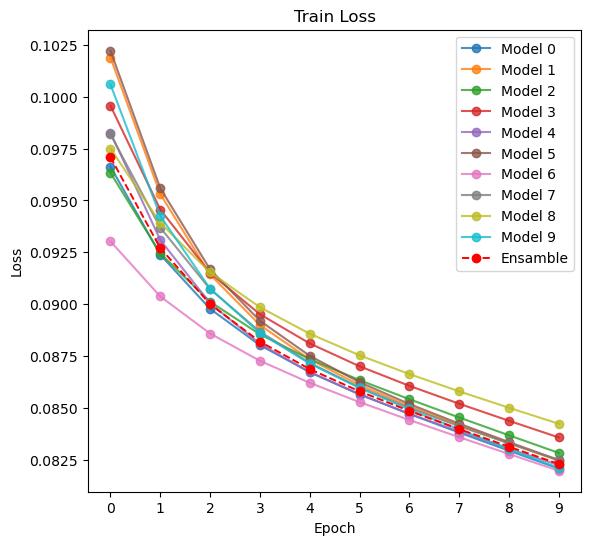

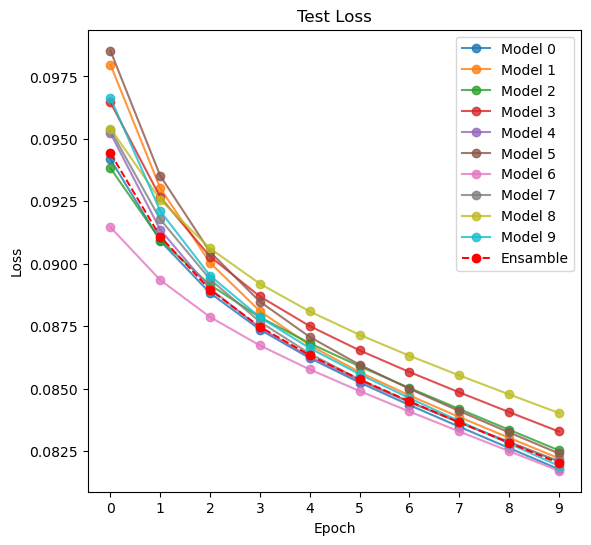

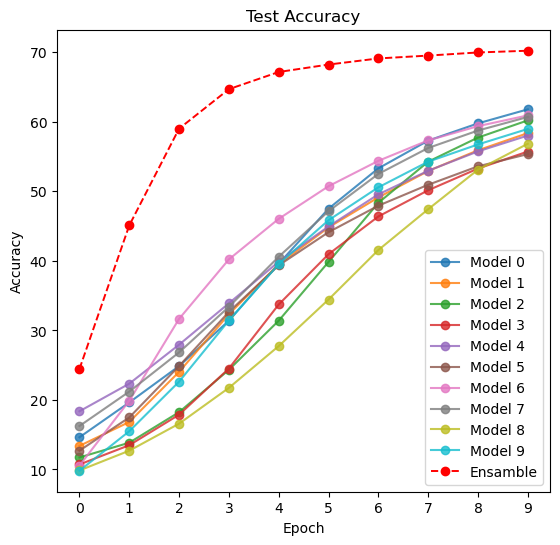

In [21]:
plot_models_metrics(train_losses, test_losses, test_accuracies, ensamble_last=True)

## Now let's train multiple EnsambleModels

In [22]:
models = [NeuralNetwork().to(device) for _ in range(MODELS_NUM)]
ensamble_model = EnsambleModel(models)
optimizers = [torch.optim.SGD(model.parameters(), lr=learning_rate) for model in models]

In [23]:
train_losses = [list() for _ in range(MODELS_NUM + 1)]
test_losses = [list() for _ in range(MODELS_NUM + 1)]
test_accuracies = [list() for _ in range(MODELS_NUM + 1)]

In [24]:
from random import sample

# Define how many ensemble models to train and how many base models to use per ensemble
ENSEMBLE_MODELS_NUM = 3
BASE_MODELS_PER_ENSEMBLE = 5

# Generate ensemble subsets
ensemble_subsets = [
    sample(models, BASE_MODELS_PER_ENSEMBLE) for _ in range(ENSEMBLE_MODELS_NUM)
]

ensemble_models = [EnsambleModel(subset).to(device) for subset in ensemble_subsets]

# Initialize metrics
train_losses_ensemble = [[] for _ in range(ENSEMBLE_MODELS_NUM)]
test_losses_ensemble = [[] for _ in range(ENSEMBLE_MODELS_NUM)]
test_accuracies_ensemble = [[] for _ in range(ENSEMBLE_MODELS_NUM)]


In [25]:
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    
    # Train base models
    models_preds = [None for _ in range(MODELS_NUM)]
    for i, (model, optimizer) in enumerate(zip(models, optimizers)):
        print(f"\tBase Model #{i + 1}")
        train_loss, model_preds = train(train_loader, model, optimizer, loss_fn, save_preds=True)
        test_loss, test_acc = test(test_loader, model, loss_fn)
        models_preds[i] = model_preds
        # Save metrics for base models
        train_losses[i].append(train_loss)
        test_losses[i].append(test_loss)
        test_accuracies[i].append(test_acc)
    
    # Train ensemble models
    for j, ensemble_model in enumerate(ensemble_models):
        print(f"\tEnsemble Model #{j + 1}")
        train_loss = EnsambleModel.calculate_loss(
            [models_preds[models.index(base_model)] for base_model in ensemble_model.model_list],
            all_labels,
            loss_fn,
        )
        print(f"\tTrain Loss: {train_loss:>8f}")
        test_loss, test_acc = test(test_loader, ensemble_model, loss_fn)
        
        # Save metrics for ensemble models
        train_losses_ensemble[j].append(train_loss)
        test_losses_ensemble[j].append(test_loss)
        test_accuracies_ensemble[j].append(test_acc)
print("Done!")

Epoch 1
-------------------------------
	Base Model #1
	loss: 0.098715  [   64/ 5000]
	loss: 0.095377  [ 2304/ 5000]
	loss: 0.093411  [ 4544/ 5000]
	Avg loss: 0.09566107609226734
	Test Error: 
	Accuracy: 16.9%, Avg loss: 0.093446 

	Base Model #2
	loss: 0.109661  [   64/ 5000]
	loss: 0.104433  [ 2304/ 5000]
	loss: 0.100371  [ 4544/ 5000]
	Avg loss: 0.10453330168995677
	Test Error: 
	Accuracy: 12.5%, Avg loss: 0.100059 

	Base Model #3
	loss: 0.099890  [   64/ 5000]
	loss: 0.096121  [ 2304/ 5000]
	loss: 0.094677  [ 4544/ 5000]
	Avg loss: 0.09637415324208103
	Test Error: 
	Accuracy: 20.8%, Avg loss: 0.094039 

	Base Model #4
	loss: 0.100891  [   64/ 5000]
	loss: 0.098565  [ 2304/ 5000]
	loss: 0.096134  [ 4544/ 5000]
	Avg loss: 0.09816213753781741
	Test Error: 
	Accuracy: 11.4%, Avg loss: 0.095397 

	Base Model #5
	loss: 0.101135  [   64/ 5000]
	loss: 0.098490  [ 2304/ 5000]
	loss: 0.095754  [ 4544/ 5000]
	Avg loss: 0.09884562786621383
	Test Error: 
	Accuracy: 13.9%, Avg loss: 0.095718 



## Visualize Ensemble Models learning process

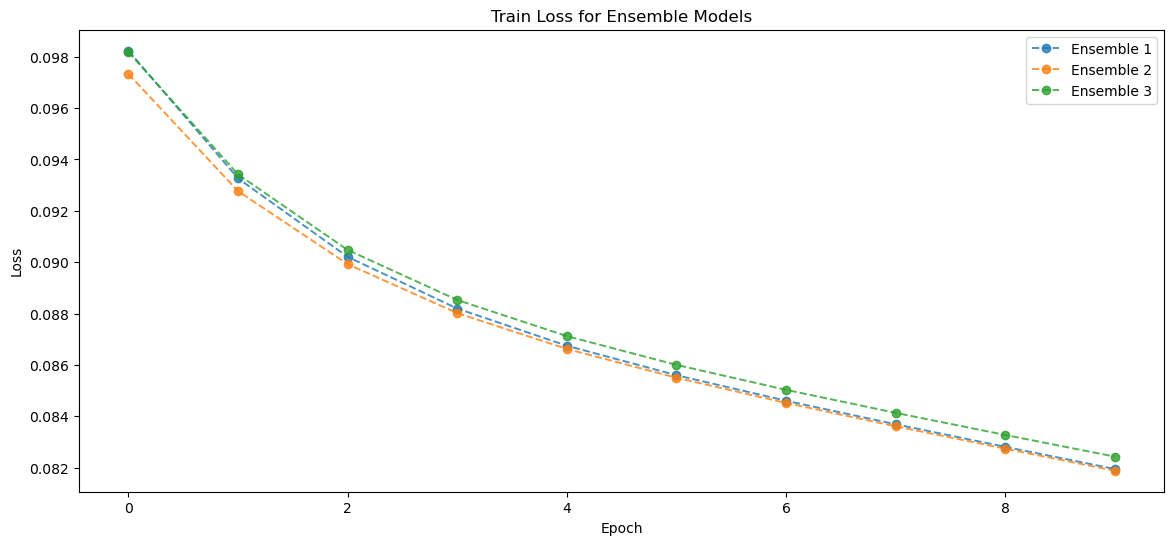

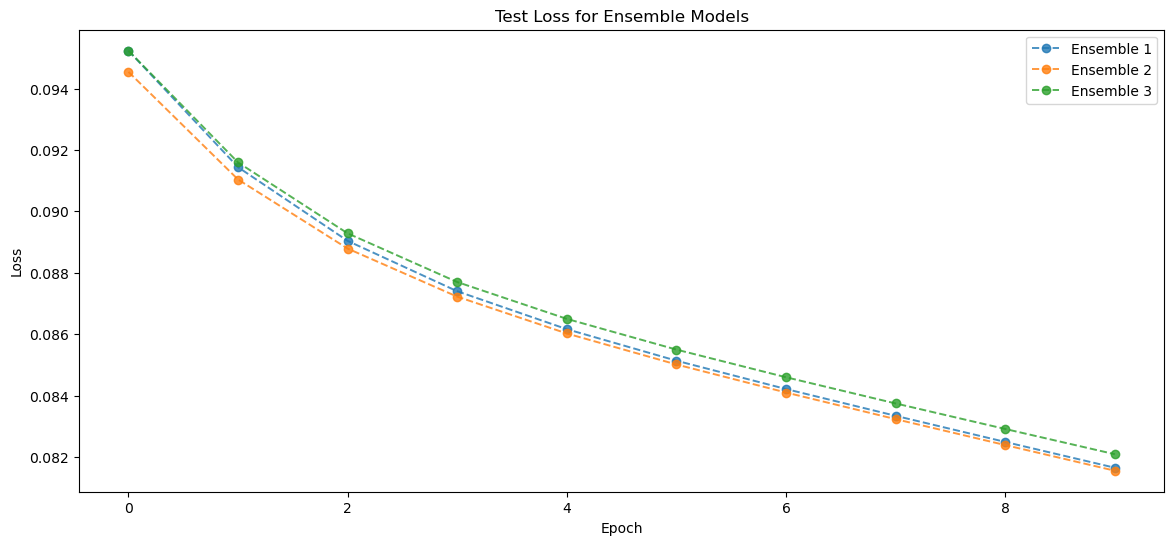

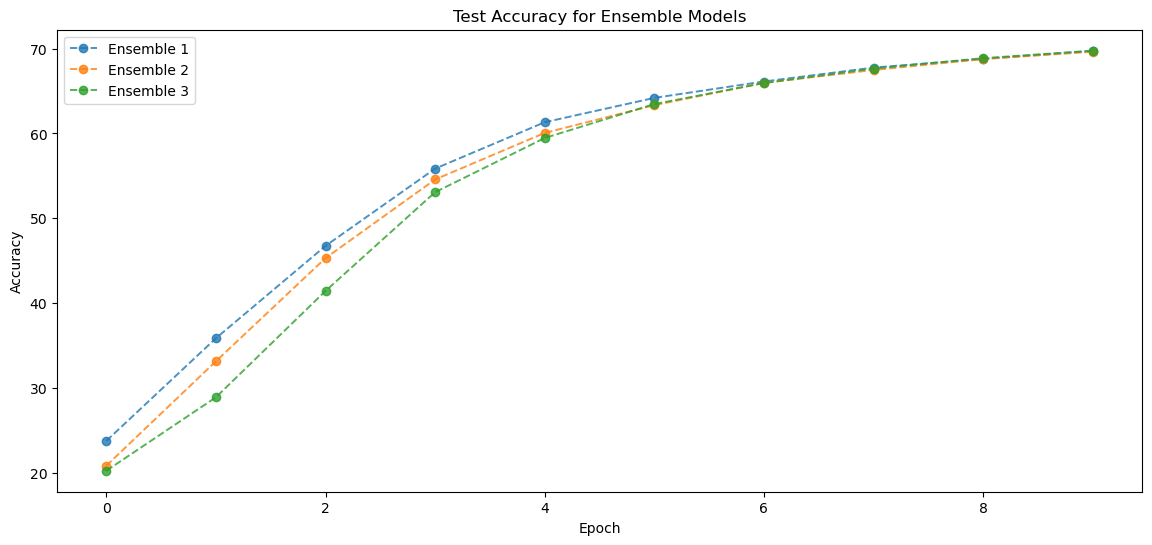

In [26]:
def plot_ensemble_metrics(train_losses_ensemble, test_losses_ensemble, test_accuracies_ensemble):
    def plot_metric(metric, title, ylabel):
        plt.figure(figsize=(14, 6))
        for i, model_metric in enumerate(metric):
            plt.plot(model_metric, label=f"Ensemble {i + 1}", marker="o", linestyle="--", linewidth=1.4, alpha=0.8)
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

    plot_metric(train_losses_ensemble, "Train Loss for Ensemble Models", "Loss")
    plot_metric(test_losses_ensemble, "Test Loss for Ensemble Models", "Loss")
    plot_metric(test_accuracies_ensemble, "Test Accuracy for Ensemble Models", "Accuracy")

plot_ensemble_metrics(train_losses_ensemble, test_losses_ensemble, test_accuracies_ensemble)


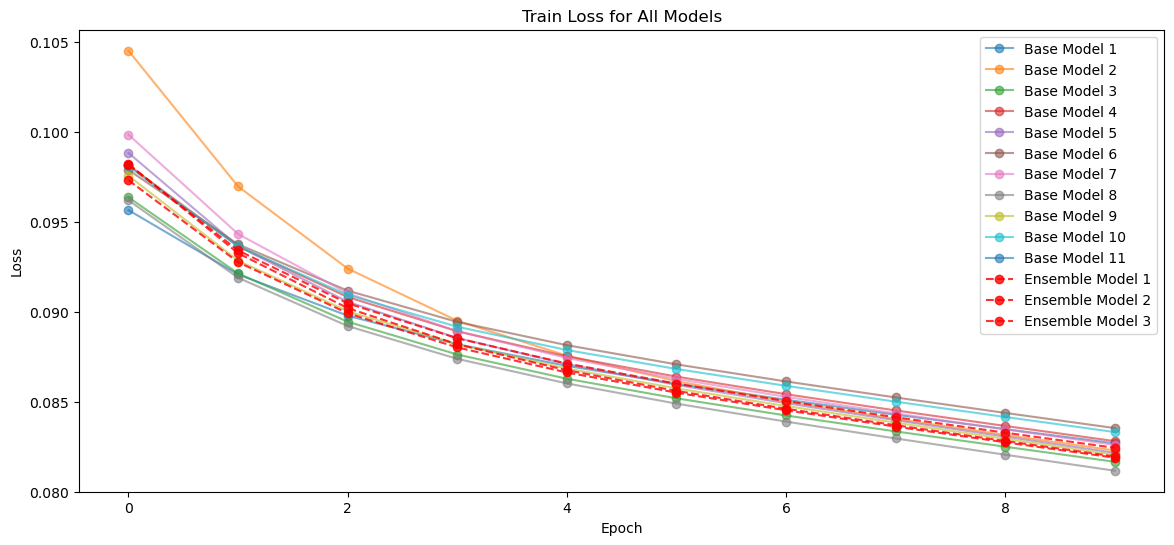

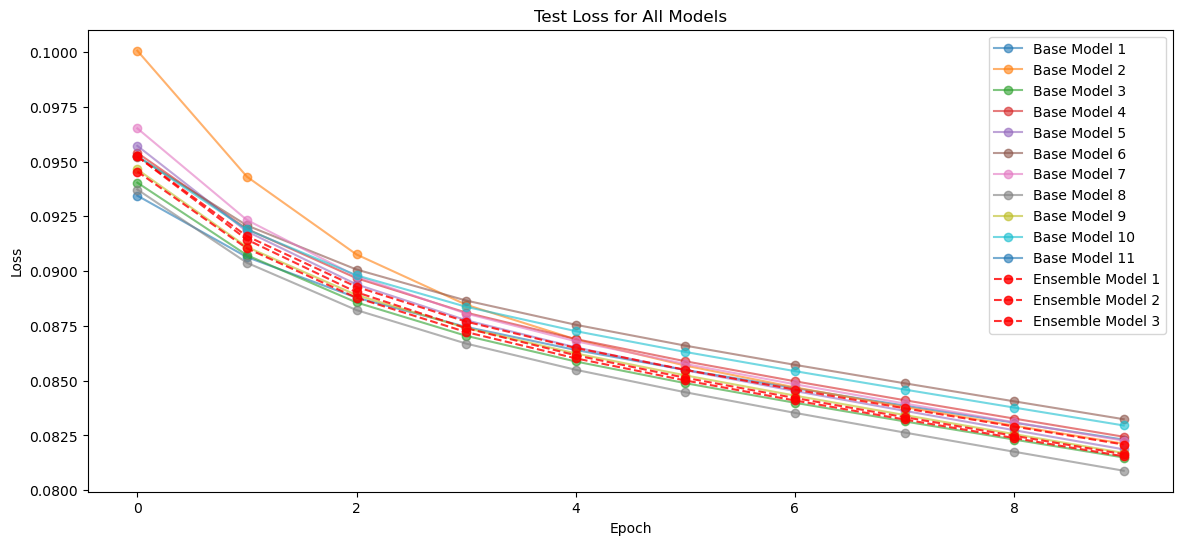

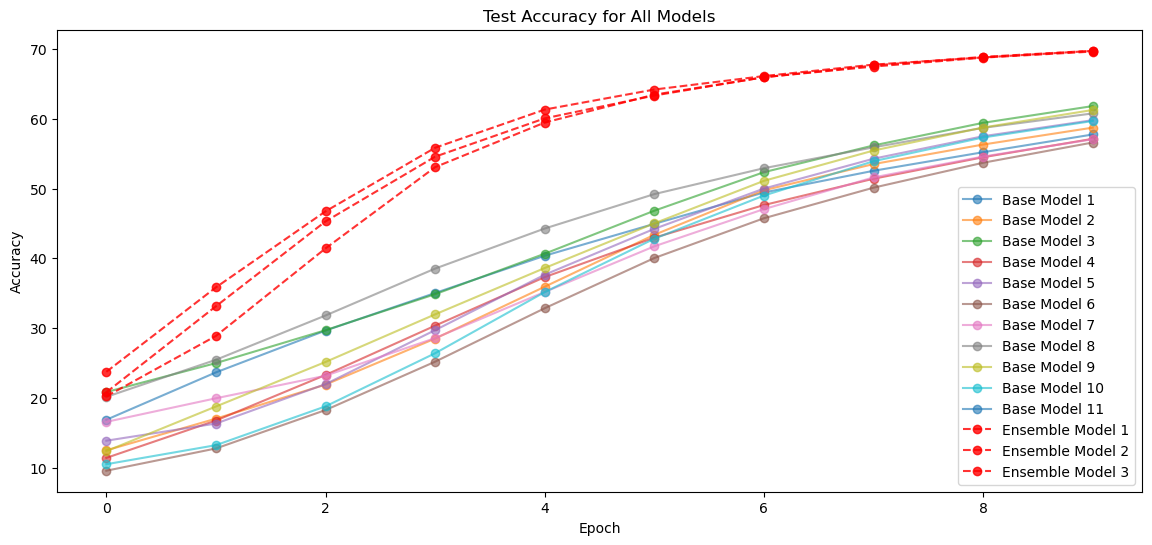

In [27]:
# ## Visualize Base and Ensemble Models Together
def plot_all_models(train_losses, test_losses, test_accuracies, train_losses_ensemble, test_losses_ensemble,
                    test_accuracies_ensemble):
    def plot_metric(metric_base, metric_ensemble, title, ylabel):
        plt.figure(figsize=(14, 6))
        for i, model_metric in enumerate(metric_base):
            plt.plot(model_metric, label=f"Base Model {i + 1}", marker="o", alpha=0.6)

        for j, ensemble_metric in enumerate(metric_ensemble):
            plt.plot(
                ensemble_metric,
                label=f"Ensemble Model {j + 1}",
                color="red",
                marker="o",
                linestyle="--",
                linewidth=1.5,
                alpha=0.8,
            )

        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

    plot_metric(train_losses, train_losses_ensemble, "Train Loss for All Models", "Loss")
    plot_metric(test_losses, test_losses_ensemble, "Test Loss for All Models", "Loss")
    plot_metric(test_accuracies, test_accuracies_ensemble, "Test Accuracy for All Models", "Accuracy")


plot_all_models(train_losses, test_losses, test_accuracies, train_losses_ensemble, test_losses_ensemble,
                test_accuracies_ensemble)
